In [222]:
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.utils.data import random_split
from torchsummary import summary
from tqdm import tqdm



In [223]:
torch.manual_seed(41)

In [224]:
os.listdir('Leaf/Data')[:5]

['Ilex_Cornuta',
 'Quercus_Castaneifolia',
 'Quercus_Pyrenaica',
 'Quercus_Ellipsoidalis',
 'Viburnum_Tinus']

In [225]:
%store -r class_label

In [226]:
class_label[:5]

['Acer_Opalus',
 'Pterocarya_Stenoptera',
 'Quercus_Hartwissiana',
 'Tilia_Tomentosa',
 'Quercus_Variabilis']

In [227]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [228]:
device

device(type='cpu')

In [254]:
root = 'Leaf/Data'

In [255]:
transform = transforms.Compose([transforms.Resize((50,50)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

In [256]:
dataset = datasets.ImageFolder(root, transform= transform)

In [257]:
# train,valid = random_split(dataset,[int(len(dataset) - len(dataset)*30/100),int(len(dataset)*30/100)])

In [258]:
train,valid = random_split(dataset,[700,290])

In [259]:
len(set(valid.dataset.classes))

99

In [260]:
len(set(train.dataset.classes))

99

In [236]:
len(dataset)*30/100

297.0

In [237]:
len(train)

700

In [261]:
train.dataset.transform = transforms.Compose([transforms.Resize((50,50)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

In [262]:
train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True,drop_last=True )
valid_loader = torch.utils.data.DataLoader(valid, batch_size=64, shuffle=False,drop_last=True )

In [263]:
def imshow(img):
    img = img/2 +0.5
    plt.imshow(np.transpose(img, (1,2,0)))

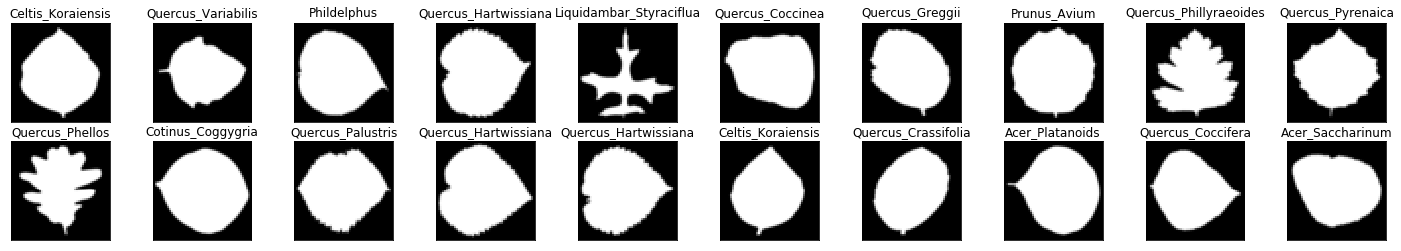

In [264]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_label[labels[idx]])

In [265]:
class LeafNet1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,20,5,1)
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.conv1_bn = nn.BatchNorm2d(20)
        self.conv2_bn = nn.BatchNorm2d(50)
        self.conv3 = nn.Conv2d(50,800,4,1)
        self.conv3_bn = nn.BatchNorm2d(800)
        self.linear1 = nn.Linear(800,350)
        self.linear2 = nn.Linear(350,99)


        # Dropout module with 0.2 drop probability
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.4)

    def forward(self, x):
        # make sure input tensor is flattened

        # Now with dropout
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool2d(x,4,4)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.max_pool2d(x,2,2)
        x = x.view(64, -1)
        x = self.dropout1(x)
        x = F.relu(self.linear1(x))
        x = self.dropout2(x)
        x = self.linear2(x)


        # output so no dropout here

        return x

In [271]:
class LeafNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,28,3,1)
        self.conv2 = nn.Conv2d(28,32,3,1)
        self.conv1_bn = nn.BatchNorm2d(28)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,3,1)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.linear1 = nn.Linear(1024,256)
        self.linear2 = nn.Linear(256,99)


        # Dropout module with 0.2 drop probability
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.4)

    def forward(self, x):
        # make sure input tensor is flattened

        # Now with dropout
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.max_pool2d(x,2,2)
        x = x.view(64,1024)
#         x = self.dropout1(x)
        x = F.relu(self.linear1(x))
        x = self.dropout2(x)
        x = self.linear2(x)


        # output so no dropout here

        return x

In [272]:
model = LeafNet2().to(device)
model

LeafNet2(
  (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(28, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=1024, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=99, bias=True)
  (dropout1): Dropout(p=0.3)
  (dropout2): Dropout(p=0.4)
)

In [273]:
summary(model,(3,45,45))

RuntimeError: shape '[64, 1024]' is invalid for input of size 1152

In [275]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

In [276]:
epochs = 35
steps = 0

train_losses, test_losses = [], []
for e in tqdm(range(epochs)):
    running_loss = 0
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in valid_loader:
                
                log_ps = model(images)
            
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(valid_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(valid_loader)))









  0%|          | 0/35 [00:00<?, ?it/s]







  3%|▎         | 1/35 [00:06<03:31,  6.21s/it]

Epoch: 1/35..  Training Loss: 4.604..  Test Loss: 4.581..  Test Accuracy: 0.039










  6%|▌         | 2/35 [00:11<03:19,  6.05s/it]

Epoch: 2/35..  Training Loss: 4.149..  Test Loss: 4.406..  Test Accuracy: 0.035










  9%|▊         | 3/35 [00:17<03:11,  5.99s/it]

Epoch: 3/35..  Training Loss: 3.749..  Test Loss: 3.952..  Test Accuracy: 0.094










 11%|█▏        | 4/35 [00:23<03:04,  5.96s/it]

Epoch: 4/35..  Training Loss: 3.292..  Test Loss: 3.304..  Test Accuracy: 0.266










 14%|█▍        | 5/35 [00:29<02:58,  5.93s/it]

Epoch: 5/35..  Training Loss: 2.857..  Test Loss: 2.784..  Test Accuracy: 0.344










 17%|█▋        | 6/35 [00:35<02:52,  5.95s/it]

Epoch: 6/35..  Training Loss: 2.537..  Test Loss: 2.492..  Test Accuracy: 0.363










 20%|██        | 7/35 [00:41<02:46,  5.93s/it]

Epoch: 7/35..  Training Loss: 2.325..  Test Loss: 2.178..  Test Accuracy: 0.434










 23%|██▎       | 8/35 [00:47<02:41,  5.97s/it]

Epoch: 8/35..  Training Loss: 1.995..  Test Loss: 1.959..  Test Accuracy: 0.457










 26%|██▌       | 9/35 [00:53<02:36,  6.04s/it]

Epoch: 9/35..  Training Loss: 1.809..  Test Loss: 1.863..  Test Accuracy: 0.512










 29%|██▊       | 10/35 [00:59<02:31,  6.06s/it]

Epoch: 10/35..  Training Loss: 1.592..  Test Loss: 1.687..  Test Accuracy: 0.555










 31%|███▏      | 11/35 [01:05<02:26,  6.11s/it]

Epoch: 11/35..  Training Loss: 1.420..  Test Loss: 1.573..  Test Accuracy: 0.586










 34%|███▍      | 12/35 [01:12<02:21,  6.14s/it]

Epoch: 12/35..  Training Loss: 1.294..  Test Loss: 1.452..  Test Accuracy: 0.605










 37%|███▋      | 13/35 [01:18<02:17,  6.25s/it]

Epoch: 13/35..  Training Loss: 1.133..  Test Loss: 1.396..  Test Accuracy: 0.617










 40%|████      | 14/35 [01:24<02:10,  6.21s/it]

Epoch: 14/35..  Training Loss: 1.071..  Test Loss: 1.368..  Test Accuracy: 0.625










 43%|████▎     | 15/35 [01:30<02:04,  6.20s/it]

Epoch: 15/35..  Training Loss: 0.978..  Test Loss: 1.288..  Test Accuracy: 0.688










 46%|████▌     | 16/35 [01:37<01:57,  6.21s/it]

Epoch: 16/35..  Training Loss: 0.830..  Test Loss: 1.392..  Test Accuracy: 0.625










 49%|████▊     | 17/35 [01:43<01:51,  6.17s/it]

Epoch: 17/35..  Training Loss: 0.824..  Test Loss: 1.218..  Test Accuracy: 0.676










 51%|█████▏    | 18/35 [01:49<01:44,  6.14s/it]

Epoch: 18/35..  Training Loss: 0.692..  Test Loss: 1.159..  Test Accuracy: 0.668










 54%|█████▍    | 19/35 [01:55<01:38,  6.16s/it]

Epoch: 19/35..  Training Loss: 0.658..  Test Loss: 1.192..  Test Accuracy: 0.668










 57%|█████▋    | 20/35 [02:01<01:32,  6.15s/it]

Epoch: 20/35..  Training Loss: 0.575..  Test Loss: 1.149..  Test Accuracy: 0.680










 60%|██████    | 21/35 [02:07<01:25,  6.14s/it]

Epoch: 21/35..  Training Loss: 0.595..  Test Loss: 1.192..  Test Accuracy: 0.664










 63%|██████▎   | 22/35 [02:14<01:20,  6.18s/it]

Epoch: 22/35..  Training Loss: 0.472..  Test Loss: 1.131..  Test Accuracy: 0.691










 66%|██████▌   | 23/35 [02:20<01:14,  6.22s/it]

Epoch: 23/35..  Training Loss: 0.459..  Test Loss: 1.294..  Test Accuracy: 0.668










 69%|██████▊   | 24/35 [02:26<01:08,  6.20s/it]

Epoch: 24/35..  Training Loss: 0.421..  Test Loss: 1.171..  Test Accuracy: 0.695










 71%|███████▏  | 25/35 [02:32<01:02,  6.21s/it]

Epoch: 25/35..  Training Loss: 0.391..  Test Loss: 1.151..  Test Accuracy: 0.715










 74%|███████▍  | 26/35 [02:38<00:55,  6.18s/it]

Epoch: 26/35..  Training Loss: 0.346..  Test Loss: 1.116..  Test Accuracy: 0.703










 77%|███████▋  | 27/35 [02:45<00:50,  6.27s/it]

Epoch: 27/35..  Training Loss: 0.365..  Test Loss: 1.240..  Test Accuracy: 0.660










 80%|████████  | 28/35 [02:51<00:43,  6.24s/it]

Epoch: 28/35..  Training Loss: 0.315..  Test Loss: 1.115..  Test Accuracy: 0.699










 83%|████████▎ | 29/35 [02:57<00:36,  6.16s/it]

Epoch: 29/35..  Training Loss: 0.299..  Test Loss: 1.148..  Test Accuracy: 0.691










 86%|████████▌ | 30/35 [03:03<00:30,  6.16s/it]

Epoch: 30/35..  Training Loss: 0.249..  Test Loss: 1.150..  Test Accuracy: 0.691










 89%|████████▊ | 31/35 [03:09<00:24,  6.16s/it]

Epoch: 31/35..  Training Loss: 0.248..  Test Loss: 1.052..  Test Accuracy: 0.707










 91%|█████████▏| 32/35 [03:16<00:18,  6.17s/it]

Epoch: 32/35..  Training Loss: 0.214..  Test Loss: 1.108..  Test Accuracy: 0.688










 94%|█████████▍| 33/35 [03:22<00:12,  6.17s/it]

Epoch: 33/35..  Training Loss: 0.239..  Test Loss: 1.208..  Test Accuracy: 0.676










 97%|█████████▋| 34/35 [03:28<00:06,  6.14s/it]

Epoch: 34/35..  Training Loss: 0.227..  Test Loss: 1.224..  Test Accuracy: 0.680










100%|██████████| 35/35 [03:34<00:00,  6.12s/it]









Epoch: 35/35..  Training Loss: 0.195..  Test Loss: 1.155..  Test Accuracy: 0.707


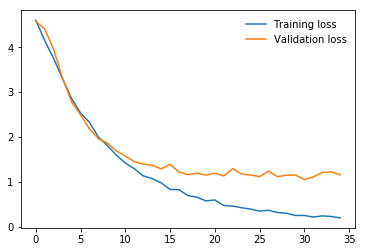

In [277]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

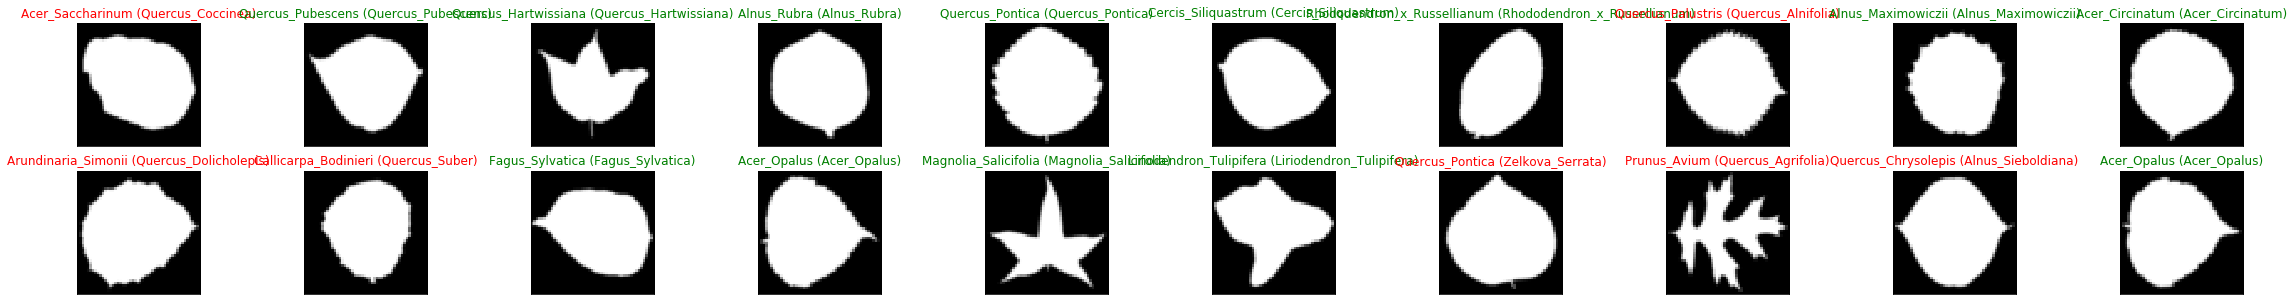

In [278]:
# obtain one batch of test images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not 0 else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(40, 5))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(class_label[preds[idx]], class_label[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))


In [280]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(99))
class_total = list(0. for i in range(99))

model.eval() # prep model for evaluation

for data, target in valid_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(valid_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(99):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            class_label[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_label[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.017249

Test Accuracy of Acer_Opalus: 100% ( 4/ 4)
Test Accuracy of Pterocarya_Stenoptera: N/A (no training examples)
Test Accuracy of Quercus_Hartwissiana: 100% ( 5/ 5)
Test Accuracy of Tilia_Tomentosa: 100% ( 1/ 1)
Test Accuracy of Quercus_Variabilis: 100% ( 4/ 4)
Test Accuracy of Magnolia_Salicifolia: 80% ( 4/ 5)
Test Accuracy of Quercus_Canariensis: 100% ( 1/ 1)
Test Accuracy of Quercus_Rubra: 100% ( 1/ 1)
Test Accuracy of Quercus_Brantii: 100% ( 2/ 2)
Test Accuracy of Salix_Fragilis: N/A (no training examples)
Test Accuracy of Zelkova_Serrata: 75% ( 3/ 4)
Test Accuracy of Betula_Austrosinensis: 100% ( 1/ 1)
Test Accuracy of Quercus_Pontica: 66% ( 2/ 3)
Test Accuracy of Quercus_Afares: 100% ( 2/ 2)
Test Accuracy of Quercus_Coccifera: 100% ( 1/ 1)
Test Accuracy of Fagus_Sylvatica: 100% ( 5/ 5)
Test Accuracy of Phildelphus: 66% ( 2/ 3)
Test Accuracy of Acer_Palmatum: 100% ( 3/ 3)
Test Accuracy of Quercus_Pubescens: 100% ( 3/ 3)
Test Accuracy of Populus_Adenopoda: 33% ( 1